In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.fftpack import fft, fftshift, ifft
from scipy.signal import fftconvolve
#plt.style.use('seaborn-colorblind')

plt.style.use('seaborn-talk')
cci=plt.rcParams['axes.prop_cycle'].by_key()['color']


import seaborn as sns
from matplotlib.transforms import Bbox

sns.set(style='white',font_scale=1.4)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
lsc= ['-','--']
lw = [4,3]
lc = ['Gaussian','Top Hat']
cc = [cci[0],cci[1]]

In [4]:
mas = 4.84814e-9       #radians
au  = 1.495978707e11   #meters
c   = 2.99792458e8     #meters
pc  = 3.0857e16        #meters
re  = 2.8179403227e-15 #meters

In [5]:
dlens = 389.*pc
dpsr  = 620.*pc
lo0    = c/(314.5e6)

la   = 1.0e5*au
T    = 0.03*au
A    = 0.3*au
inc  = 1.0e-5

R  = la**2./(4.*np.pi**2.*A*np.cos(inc)**3.*np.sqrt(1.-la**2./(4.*np.pi**2.*A**2.)*np.tan(inc)**2.))
s  = 1. - dlens/dpsr
r  = R/dlens
t  = T/dlens

def dn(dne,lo):
    re  = 2.8179403227e-15 #meters
    return -1. * lo**2. * dne * re / (2.*np.pi)

dne = 0.3*1e6

In [6]:
print(r'R = {:.2f} pc'.format(R/pc))
print(r'T = {} AU'.format(T/au))
print(r'r = {:.2f}'.format(r))
print(r't = {:.4f} mas'.format(t/mas))
print(r's = {:.4f}'.format(s))

R = 4829.05 pc
T = 0.03 AU
r = 12.41
t = 0.0771 mas
s = 0.3726


### Lens Profile:

In [7]:
def gaus(x,m,s):
    return np.median(np.diff(x))/((2*np.pi)**(1/2)*s)*np.exp(-(x-m)**2/(2*s**2))
def zouter(x,R,T):
    return 2*T*(1+R/(2*x))**(1/2)
def tophat(x,xmin,xmax):
    return np.median(np.diff(x))/(xmax-xmin)*(xmin<x)*(x<xmax)

In [8]:
x = np.arange(-3000.*mas*dlens,3000.*mas*dlens,T/10.)
idxp=np.searchsorted(x,T/2,side='left')
idxm=np.searchsorted(x,-T/2,side='left')
idx0=np.searchsorted(x,0,side='left')

# the profile to be convolved
z1 = np.zeros(x.shape)
z1[idx0:] = zouter(x[idx0:],R,T) 

# Change x and z to units of 
x,z1 = x/T,z1/T

# Convolve
z1c = fftconvolve(z1,gaus(x,0,1/(2*np.sqrt(2*np.log(2)))),mode='same')
z2c = fftconvolve(z1,tophat(x,-0.5,0.5),mode='same')

### Gradient:

In [9]:
gradz1c = np.gradient(z1c,np.median(np.diff(x)))
gradz2c = np.gradient(z2c,np.median(np.diff(x)))

In [10]:
z1c      = z1c[len(x)//4:3*len(x)//4]
z2c      = z2c[len(x)//4:3*len(x)//4]
gradz1c  = gradz1c[len(x)//4:3*len(x)//4]
gradz2c  = gradz2c[len(x)//4:3*len(x)//4]
x        = x[len(x)//4:3*len(x)//4]

z = [z1c,z2c]
grad = [gradz1c,gradz2c]

[Text(0,0,'-1.0e5'),
 Text(0,0,'0.0'),
 Text(0,0,'1.0e5'),
 Text(0,0,'2.0e5'),
 Text(0,0,'3.0e5'),
 Text(0,0,'4.0e5'),
 Text(0,0,'5.0e5')]

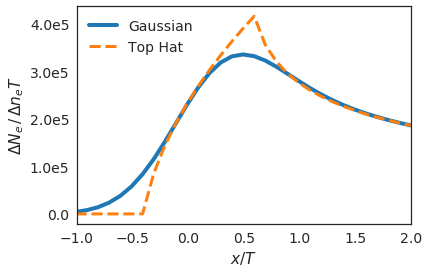

In [11]:
fig,ax = plt.subplots()
for i in range(2):
    ax.plot(x,z[i],cc[i],ls=lsc[i],label=lc[i],linewidth=lw[i])

ax.set_ylabel(r'$\Delta N_e \,/\, \Delta n_e T$')
ax.legend(loc='upper left')
ax.set_xlabel(r'$x/T$')
ax.set_xlim(-1,2)
yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    if ytick == 0:
        ylabels += [str(ytick)]
    else:
        ylabels += [str(ytick/1e5)+'e5']
ax.set_yticklabels(ylabels)

In [12]:
theta = x*T/dlens
def beta(theta,dn,s,gradz):
    return theta + dn * s * gradz
def mu(theta,dn,s,gradz):
    return 1./np.gradient(beta(theta,dn,s,gradz),np.median(np.diff(theta)))
def defl(theta,dn,s,gradz):
    return -dn * s * gradz

## Change in number of images with beta and wavelength

In [13]:
from matplotlib.colors import LinearSegmentedColormap
cmap = plt.cm.gray
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::-len(cmaplist)//4][:3]
cm = LinearSegmentedColormap.from_list(
        'discrete', cmaplist, N=len(cmaplist))

### Overdense

In [14]:
los   = 10**np.arange(-3,2,0.001)
betas = np.arange(-500,500,10)*mas

In [15]:
nimages_od    = np.zeros((len(los),len(betas)),dtype=np.int)

In [16]:
for i in range(len(los)):
    beta_obs = beta(theta,dn(dne,los[i]),s,grad[0])
    for j in range(len(betas)):
        idx = np.argwhere(np.diff(np.sign(beta_obs - betas[j])) != 0).reshape(-1) 
        nimages_od[i,j] = len(idx)

### Underdense

In [17]:
nimages_ud    = np.zeros((len(los),len(betas)),dtype=np.int)

In [18]:
for i in range(len(los)):
    beta_obs = beta(theta,dn(-dne,los[i]),s,grad[0])
    for j in range(len(betas)):
        idx = np.argwhere(np.diff(np.sign(beta_obs - betas[j])) != 0).reshape(-1) 
        nimages_ud[i,j] = len(idx)

In [19]:
freqs = c/los/1e9

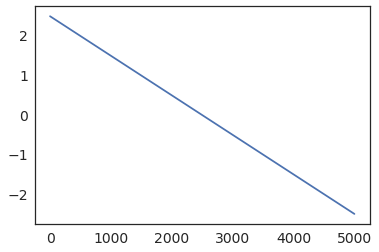

In [20]:
plt.plot(np.log10(freqs))

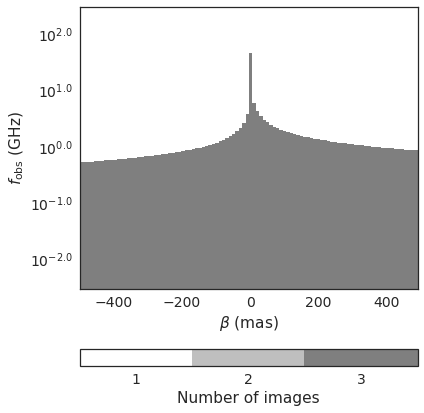

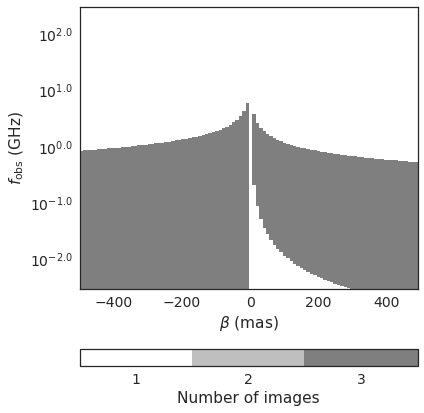

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,6),sharey=True,sharex=True)
cax=ax.imshow(nimages_ud,aspect='auto',interpolation='none',vmin=0.5,vmax=3.5,
          extent=[betas[0]/mas,betas[-1]/mas,np.log10(freqs[-1]),np.log10(freqs[0])],cmap=cm)
ax.set_xlabel(r'$\beta$ (mas)')
ax.set_ylabel(r'$f_\mathrm{obs}$ (GHz)')


yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    ylabels += [r'$10^{'+str(ytick)+'}$']
ax.set_yticklabels(ylabels)

fig.colorbar(cax,orientation='horizontal',ticks=[0,1,2,3],label='Number of images')
plt.tight_layout()
plt.savefig('nimages_smooth_underdense.pdf')


fig,ax = plt.subplots(1,1,figsize=(6,6),sharey=True,sharex=True)
cax=ax.imshow(nimages_od,aspect='auto',interpolation='none',vmin=0.5,vmax=3.5,
          extent=[betas[0]/mas,betas[-1]/mas,np.log10(freqs[-1]),np.log10(freqs[0])],cmap=cm)
ax.set_xlabel(r'$\beta$ (mas)')
ax.set_ylabel(r'$f_\mathrm{obs}$ (GHz)')


yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    ylabels += [r'$10^{'+str(ytick)+'}$']
ax.set_yticklabels(ylabels)

fig.colorbar(cax,orientation='horizontal',ticks=[0,1,2,3],label='Number of images')
plt.tight_layout()
plt.savefig('nimages_smooth_overdense.pdf')

## Zoom out to look at larger beta

In [279]:
x = np.arange(-30000.*mas*dlens,30000.*mas*dlens,T)
idxp=np.searchsorted(x,T/2,side='left')
idxm=np.searchsorted(x,-T/2,side='left')
idx0=np.searchsorted(x,0,side='left')

# the profile to be convolved
z1 = np.zeros(x.shape)
z1[idx0:] = zouter(x[idx0:],R,T) 

# Change x and z to units of 
x,z1 = x/T,z1/T

# Convolve
z1c = fftconvolve(z1,gaus(x,0,1/(2*np.sqrt(2*np.log(2)))),mode='same')
z2c = fftconvolve(z1,tophat(x,-0.5,0.5),mode='same')

In [280]:
gradz1c = np.gradient(z1c,np.median(np.diff(x)))
gradz2c = np.gradient(z2c,np.median(np.diff(x)))

In [281]:
z1c      = z1c[len(x)//4:3*len(x)//4]
z2c      = z2c[len(x)//4:3*len(x)//4]
gradz1c  = gradz1c[len(x)//4:3*len(x)//4]
gradz2c  = gradz2c[len(x)//4:3*len(x)//4]
x        = x[len(x)//4:3*len(x)//4]

z = [z1c,z2c]
grad = [gradz1c,gradz2c]

### Overdense

In [288]:
los   = 10**np.arange(-3,2,0.001)
betas_wide = np.arange(-500000,500000,10000)*mas

In [289]:
nimages_od_wide    = np.zeros((len(los),len(betas_wide)),dtype=np.int)

In [290]:
for i in range(len(los)):
    beta_obs = beta(theta,dn(dne,los[i]),s,grad[0])
    for j in range(len(betas_wide)):
        idx = np.argwhere(np.diff(np.sign(beta_obs - betas_wide[j])) != 0).reshape(-1) 
        nimages_od_wide[i,j] = len(idx)

### Underdense

In [291]:
nimages_ud_wide    = np.zeros((len(los),len(betas_wide)),dtype=np.int)

In [292]:
for i in range(len(los)):
    beta_obs = beta(theta,dn(-dne,los[i]),s,grad[0])
    for j in range(len(betas_wide)):
        idx = np.argwhere(np.diff(np.sign(beta_obs - betas_wide[j])) != 0).reshape(-1) 
        nimages_ud_wide[i,j] = len(idx)

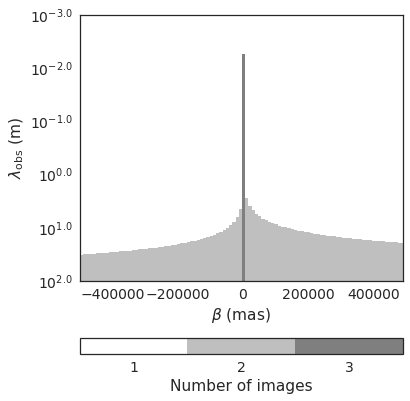

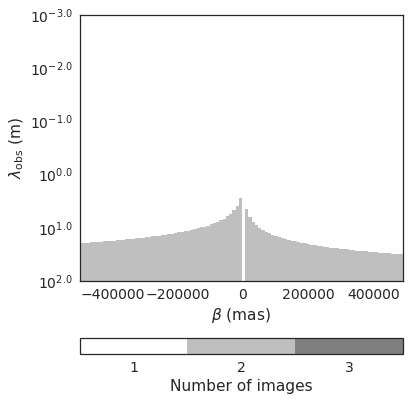

In [294]:

fig,ax = plt.subplots(1,1,figsize=(6,6),sharey=True,sharex=True)
cax=ax.imshow(nimages_ud_wide,aspect='auto',interpolation='none',vmin=0.5,vmax=3.5,
          extent=[betas_wide[0]/mas,betas_wide[-1]/mas,np.log10(los[-1]),np.log10(los[0])],cmap=cm)
ax.set_xlabel(r'$\beta$ (mas)')
ax.set_ylabel(r'$\lambda_\mathrm{obs}$ (m)')


yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    ylabels += [r'$10^{'+str(ytick)+'}$']
ax.set_yticklabels(ylabels)

fig.colorbar(cax,orientation='horizontal',ticks=[0,1,2,3],label='Number of images')
plt.tight_layout()
#plt.savefig('nimages_smooth_underdense.pdf')


fig,ax = plt.subplots(1,1,figsize=(6,6),sharey=True,sharex=True)
cax=ax.imshow(nimages_od_wide,aspect='auto',interpolation='none',vmin=0.5,vmax=3.5,
          extent=[betas_wide[0]/mas,betas_wide[-1]/mas,np.log10(los[-1]),np.log10(los[0])],cmap=cm)
ax.set_xlabel(r'$\beta$ (mas)')
ax.set_ylabel(r'$\lambda_\mathrm{obs}$ (m)')


yticks = ax.get_yticks()
ylabels = []
for ytick in yticks:
    ylabels += [r'$10^{'+str(ytick)+'}$']
ax.set_yticklabels(ylabels)

fig.colorbar(cax,orientation='horizontal',ticks=[0,1,2,3],label='Number of images')
plt.tight_layout()
#plt.savefig('nimages_smooth_overdense.pdf')

### Overdense Solution

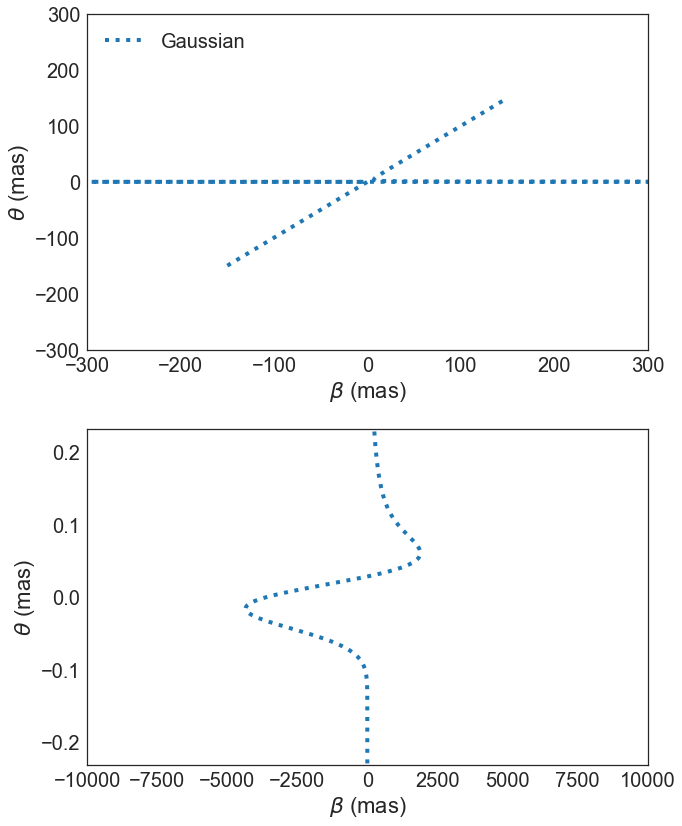

In [14]:
fig,ax = plt.subplots(2,1,figsize=(10,6*2))#,sharex=True)
ax[0].plot(beta(theta,dn(dne,lo0),s,grad  )/mas,
                   theta/mas,cc,linestyle=lsc,label=lc,linewidth=lw)
ax[0].set_ylim(-300,300)
ax[0].set_xlim(-300,300)
ax[0].legend(loc='upper left',ncol=2)
ax[0].set_ylabel(r'$\theta$ (mas)')
ax[0].set_xlabel(r'$\beta$ (mas)')

ax[1].plot(beta(theta,dn(dne,lo0),s,grad  )/mas,
               theta/mas,cc,ls=lsc,label=lc,linewidth=lw)
ax[1].set_ylim(-3*t/mas,3*t/mas)
ax[1].set_xlim(-10000,10000)
ax[1].set_xlabel(r'$\beta$ (mas)')
ax[1].set_ylabel(r'$\theta$ (mas)')

plt.tight_layout()

### Underdense Solution:

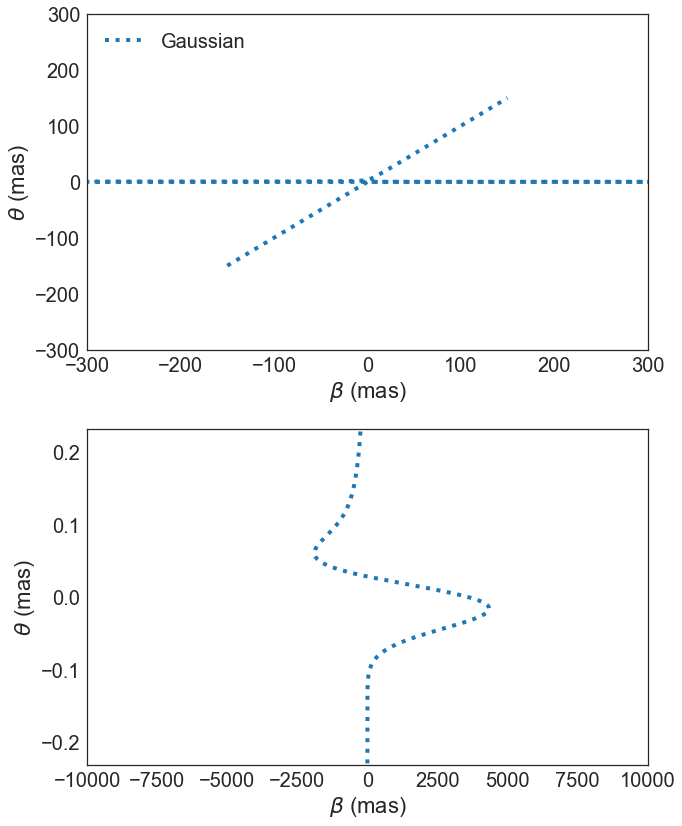

In [15]:
fig,ax = plt.subplots(2,1,figsize=(10,6*2))

ax[0].plot(beta(theta,dn(-dne,lo0),s,grad )/mas,
                   theta/mas,cc,linestyle=lsc,label=lc,linewidth=lw)
ax[0].set_ylim(-300,300)
ax[0].set_xlim(-300,300)
ax[0].legend(loc='upper left',ncol=2)
ax[0].set_ylabel(r'$\theta$ (mas)')
ax[0].set_xlabel(r'$\beta$ (mas)')

ax[1].plot(beta(theta,dn(-dne,lo0),s,grad )/mas,
               theta/mas,cc,ls=lsc,label=lc,linewidth=lw)
ax[1].set_ylim(-3*t/mas,3*t/mas)
ax[1].set_xlim(-10000,10000)
ax[1].set_xlabel(r'$\beta$ (mas)')
ax[1].set_ylabel(r'$\theta$ (mas)')

plt.tight_layout()

